# Проект №3 

## Импортируем библиотеки и читаем данные

In [89]:
import numpy as np 
import pandas as pd 

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split # инструмент для разделения датасета

# Читаем файлы
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [90]:
# для воспроизводимости эксперимента
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [91]:
# Подгружаем данные

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн


In [92]:
# Знакомимся с данными
df_train.info()
df_test.info()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [93]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [94]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [95]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [96]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['reviewer_score'] = 0 

data = df_test.append(df_train, sort=False).reset_index(drop=True) 
data = data.copy()

/tmp/ipykernel_32/930929541.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True)


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Feature Engineering

## Избавляемся от пропусков
С пропусками только значения координат

In [98]:
# список отеелей без координат
null_rows = data.isnull().any(axis=True)
display(set(data[null_rows]['hotel_address']))

{'20 Rue De La Ga t 14th arr 75014 Paris France',
 '23 Rue Damr mont 18th arr 75018 Paris France',
 '4 rue de la P pini re 8th arr 75008 Paris France',
 'Bail n 4 6 Eixample 08010 Barcelona Spain',
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
 'Pau Clar s 122 Eixample 08009 Barcelona Spain',
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 'Sep lveda 180 Eixample 08011 Barcelona Spain',
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria'}

In [99]:
coor_data = data[['hotel_address', 'lat', 'lng']]
# словарь с координатами отелей
hotel_coordinates = coor_data.groupby('hotel_address')['lat', 'lng'].first().to_dict()
# словарь с координатами отелей с карт
hotel_nan = {'lat': {'20 Rue De La Ga t 14th arr 75014 Paris France': 48.827845,
  '23 Rue Damr mont 18th arr 75018 Paris France': 48.886363,
  '4 rue de la P pini re 8th arr 75008 Paris France': 48.868109,
  'Bail n 4 6 Eixample 08010 Barcelona Spain': 41.390955,
  'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 48.222980,
  'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 48.779481,
  'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 48.210918,
  'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 48.210834,
  'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 48.19288089795001,
  'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 48.16637426860036,
  'Pau Clar s 122 Eixample 08009 Barcelona Spain': 41.39287199168932,
  'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 48.21969804202635,
  'Sep lveda 180 Eixample 08011 Barcelona Spain': 41.40156839291513,
  'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 48.246253876270494,
  'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 48.21363741266167,
  'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 48.226431942000715,
  'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 48.22620322382607},
 'lng': {'20 Rue De La Ga t 14th arr 75014 Paris France': 2.321028,
  '23 Rue Damr mont 18th arr 75018 Paris France': 2.349278,
  '4 rue de la P pini re 8th arr 75008 Paris France': 2.360294,
  'Bail n 4 6 Eixample 08010 Barcelona Spain': 2.155579,
  'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': 16.357630,
  'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': 15.657069,
  'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': 16.347119,
  'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': 16.347110,
  'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': 16.401198146858796,
  'Paragonstra e 1 11 Simmering 1110 Vienna Austria': 16.445599235618207,
  'Pau Clar s 122 Eixample 08009 Barcelona Spain': 2.1671877389652274,
  'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': 16.285581368183013,
  'Sep lveda 180 Eixample 08011 Barcelona Spain': 2.1350468077126257,
  'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': 16.34184552954927,
  'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': 16.38012185469133,
  'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': 16.356993686635533,
  'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': 16.356822025255575}}
hotel_coordinates.update(hotel_nan)


/tmp/ipykernel_32/141001643.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hotel_coordinates = coor_data.groupby('hotel_address')['lat', 'lng'].first().to_dict()


In [100]:
# функция для замены пропущенных значений
def fill_missing_coordinates(row):
    if pd.isnull(row['lat']):
        address = row['hotel_address']
        return hotel_coordinates['lat'].get(address)
    return row['lat']

data['lat'] = data.apply(fill_missing_coordinates, axis=1)
def fill_missing_coordinates(row):
    if pd.isnull(row['lng']):
        address = row['hotel_address']
        return hotel_coordinates['lng'].get(address)
    return row['lat']

data['lng'] = data.apply(fill_missing_coordinates, axis=1)

In [101]:
# проверяем, что координаты изменились
data.info()
data[data['hotel_address'] == '20 Rue De La Ga t 14th arr 75014 Paris France'].head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
3495,20 Rue De La Ga t 14th arr 75014 Paris France,22,10/18/2016,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Price too expensive for what was offered,8,377,Location,2,1,"[' Business trip ', ' Solo traveler ', ' Stand...",289 day,48.827845,2.321028,0,0.0
17635,20 Rue De La Ga t 14th arr 75014 Paris France,22,1/3/2017,7.8,Mercure Paris Gare Montparnasse,Australia,No gym,3,377,Location friendly staff good size room,7,14,"[' Leisure trip ', ' Couple ', ' Standard Room...",212 day,48.827845,2.321028,0,0.0
43533,20 Rue De La Ga t 14th arr 75014 Paris France,22,6/22/2017,7.8,Mercure Paris Gare Montparnasse,Australia,Access to shower was by the tub which is very...,54,377,No Positive,0,13,"[' Leisure trip ', ' Couple ', ' Standard Twin...",42 days,48.827845,2.321028,0,0.0


## Преобразуем признак дат, создадим новые признки

In [102]:
data['review_date'] = pd.to_datetime(data['review_date'])
# Создаём колонки дни недели, выходные, месяц, квартал
data['day']=pd.to_datetime(data['review_date']).dt.dayofweek
data['is_weekend'] = data['day'].apply(lambda x: 1 if x >= 5 else 0)
data['month']=pd.to_datetime(data['review_date']).dt.month
data['quarter']=pd.to_datetime(data['review_date']).dt.quarter

display(data)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tags,days_since_review,lat,lng,sample,reviewer_score,day,is_weekend,month,quarter
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,45.533137,0,0.0,4,0,7,3
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,52.385649,0,0.0,0,0,12,4
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,41.393192,0,0.0,3,0,11,4
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,45.479888,0,0.0,5,1,10,4
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,52.370545,0,0.0,0,0,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,2017-04-19,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,...,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,51.494028,1,8.8,2,0,4,2
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2017-02-13,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,...,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,48.192379,1,9.2,0,0,2,1
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2016-02-07,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,...,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,51.520795,1,8.3,6,1,2,1
515736,31 Great Cumberland Place Westminster Borough ...,365,2017-05-21,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,...,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,51.515125,1,9.2,6,1,5,2


## Количество дней с даты отзыва

In [103]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x[:-4]))
display(data['days_since_review'])

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review, Length: 515738, dtype: int64

## Национальность ревьюера

In [104]:
display(data['reviewer_nationality'].value_counts().head(30))
# возьмём 30 первых стран по количеству отзывов
country_list = list(data['reviewer_nationality'].value_counts().head(30).index)
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in country_list else 'other')
data['reviewer_nationality'].value_counts().head(10)

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
 Singapore                      3091
 Hong Kong                      3013
 

 United Kingdom               245246
other                          61634
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
Name: reviewer_nationality, dtype: int64

## Преобразование отзывов

In [105]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [106]:
# С помощью SentimentIntensityAnalyzer оценим отзывы по категориям: neg, pos, compound
data['neg_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
data['pos_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
data['compound_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

In [107]:
# Так же с поситивными отзывами
data['neg_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
data['pos_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
data['compound_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])


## Удаление признаков

In [108]:
drop_features = [s for s in data.columns if (data[s].dtypes == 'object')]
print(f'Нечисловые признаки для удаления: {drop_features}')
# Уберём из списка важные признаки
drop_features = ['hotel_address', 'review_date', 'hotel_name', 'negative_review', 'positive_review', 'tags', 'day']
data.drop(drop_features, axis = 1, inplace=True)


Нечисловые признаки для удаления: ['hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags']


In [109]:
# Преобразуем reviewer_nationality в category

data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')
data['reviewer_nationality'] = data['reviewer_nationality'].cat.codes

In [110]:
# Проверяем, что не осталось строковых признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int8   
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  int64  
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

## Корреляция признаков

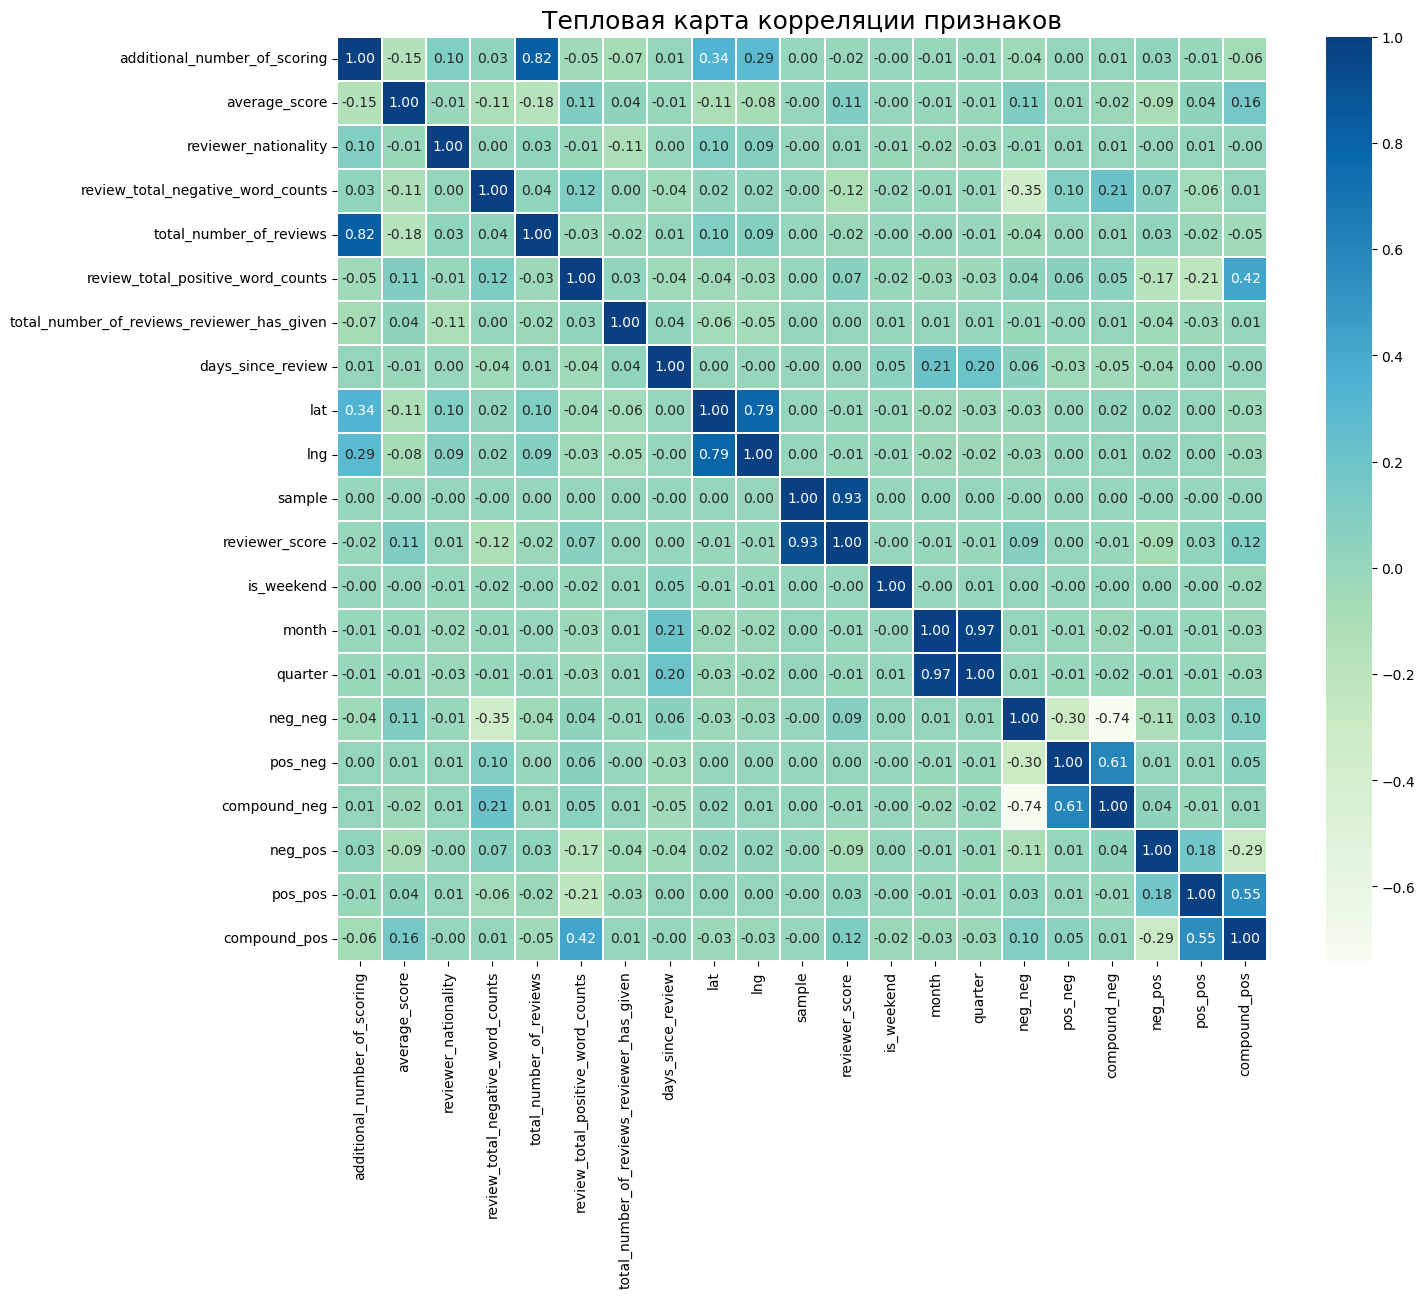

In [111]:
# Строим корреляционную тепловую карту
fig, ax = plt.subplots(figsize=(15, 12))

sns.heatmap(data.corr(method='pearson'), 
                annot=True,
                linewidths=0.1, 
                ax=ax, 
                cmap='GnBu',
                fmt='.2f')
ax.set_title('Тепловая карта корреляции признаков', fontsize=18)
plt.show()

In [112]:
# Как мы видим, есть признаки, которые сильно скоррелированны, удалим один из них
drop_ = ['total_number_of_reviews', 'lng']
data.drop(drop_, axis = 1, inplace=True)

## Проведём оценку значимости

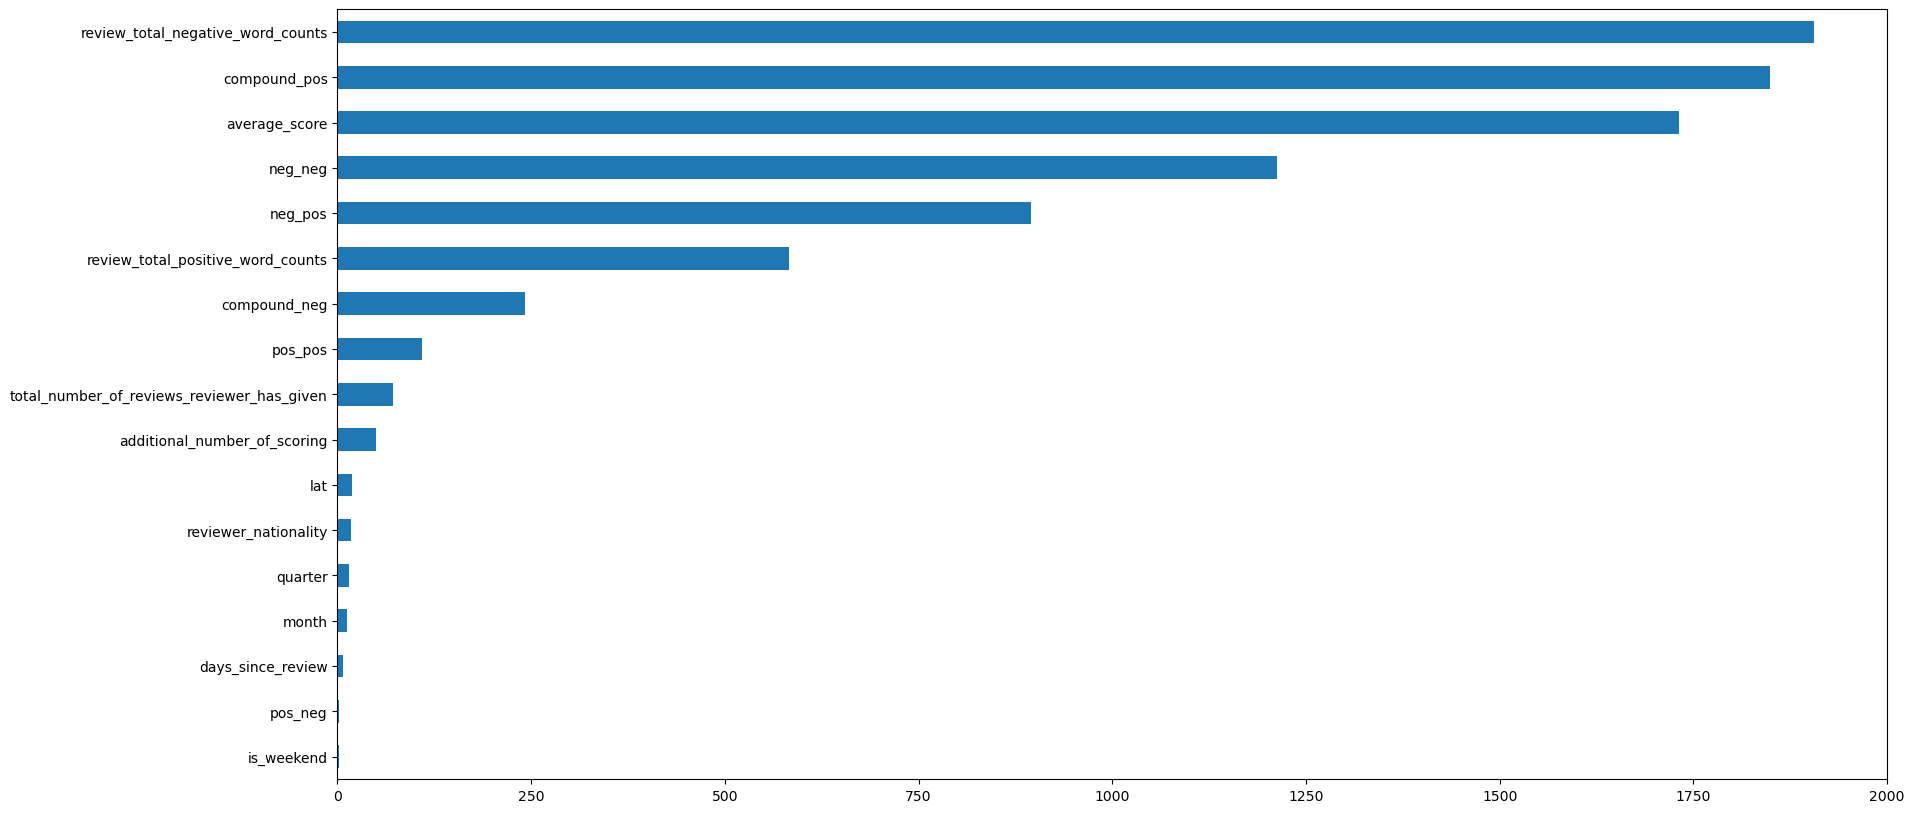

In [113]:
from sklearn.feature_selection import f_classif
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values

val = pd.Series(f_classif(X[X.columns], y)[0], 
                index = X.columns)
val.sort_values(inplace = True)
fig_, ax_ = plt.subplots(figsize=(20, 10))
val.plot(kind = 'barh');

In [114]:
# Удалим признак is_weekend, так как он совсем не влияет на данные
data.drop('is_weekend', axis = 1, inplace=True)

## Обучение модели

In [115]:
# Делим датасет на тренировочную и тестовую части,
# удалим признак sample
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
# Удаляем ключевой признак для обучения
X = train_data.drop(['reviewer_score'], axis=1)

# train_test_split для разделения тестовых данных
# возьмём 20% данных 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем размеры:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 17), (386803, 17), (386803, 16), (309442, 16), (77361, 16))

## Инструмент для создания и обучения модели RandomForestRegressor

In [116]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics # инструменты для оценки точности модели


In [117]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [118]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [119]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется MAPE и показывает среднее отклонение предсказанных значений от фактических в процентах.
def MAPE(y_test, y_pred): 
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test))*100
print('MAPE:', (MAPE(y_test, y_pred)))



MAPE: 12.559934656559262


<Axes: >

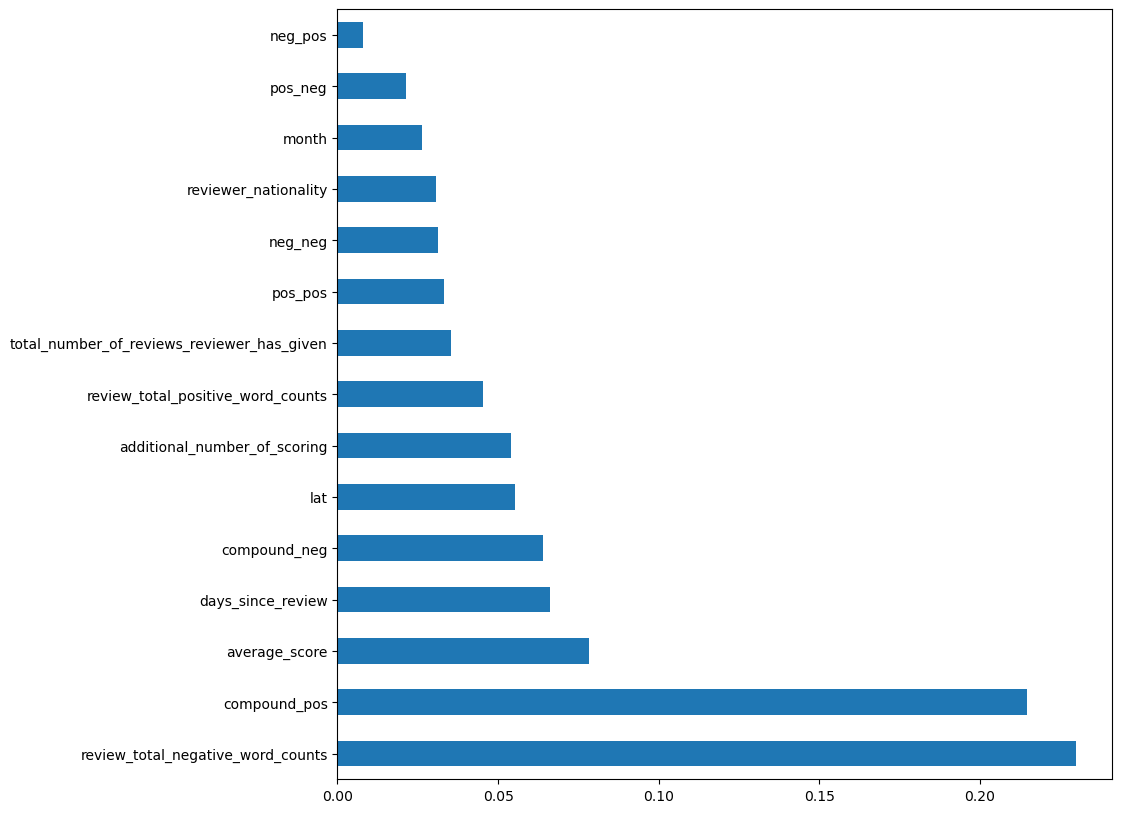

In [120]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [121]:
test_data.sample(10)

,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,reviewer_score,month,quarter,neg_neg,pos_neg,compound_neg,neg_pos,pos_pos,compound_pos
30042,36,9.6,0,0,12,1,338,48.864866,0.0,8,3,1.000,0.000,-0.7096,0.000,0.470,0.7960
99129,182,9.1,28,8,5,13,175,52.372835,0.0,2,1,0.528,0.000,-0.6802,0.000,0.778,0.7906
46208,90,7.8,28,12,0,2,0,48.843707,0.0,8,3,0.383,0.000,-0.6801,0.379,0.621,0.3400
20342,199,8.6,11,90,18,5,286,45.450131,0.0,10,4,0.118,0.082,-0.0686,0.000,0.414,0.8479
31633,853,8.4,28,13,3,1,357,51.507377,0.0,8,3,0.000,0.000,0.0000,0.000,0.787,0.5719
102347,266,8.4,0,3,9,33,583,51.509133,0.0,12,4,0.688,0.000,-0.2960,0.000,0.648,0.8481
16445,139,8.1,28,8,15,1,534,48.846837,0.0,2,1,0.241,0.000,-0.2263,0.000,0.474,0.8718
41489,514,8.9,30,0,17,3,277,52.314371,0.0,10,4,1.000,0.000,-0.7096,0.000,0.575,0.9265
99235,101,8.7,28,12,15,3,338,51.493616,0.0,8,3,0.000,0.355,0.4317,0.000,0.557,0.9062
105613,317,7.6,0,119,55,3,37,51.516114,0.0,6,2,0.000,0.029,0.4939,0.000,0.264,0.9508


In [122]:
# Удалим признак оценки из тестовых данных
test_data = test_data.drop(['reviewer_score'], axis=1)

In [123]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [124]:
# Запишем submission в файл
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.552,488440
1,7.312,274649
2,8.530,374688
3,9.752,404352
4,9.695,451596
5,8.950,302161
6,7.704,317079
7,7.356,13963
8,8.218,159785
9,7.387,195089


По итогу работы по преобразованию признаков и обученю модели удалось достичь покащателя MAPE = 12.55